In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import torch
from src.training_model import MelVAETrainer, MelGANTrainer, MelDCGANTrainer
from src.utilities.plotting_utils import (plot_spectrogram_to_numpy,
                                          plot_spectrogram_to_numpy_fixed_cbar)
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

In [4]:
%ls

LICENSE       data/                          run_tests.py  train.py
README.md     data_mean_and_std.pt           src/          waveglow/
__pycache__/  dataset_property_generator.py  tb_logs/
checkpoints/  generating_VAE.ipynb           test/


In [5]:
waveglow_path = 'waveglow/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()


/home/smehta/anaconda3/envs/LightningTacotron/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/smehta/anaconda3/envs/LightningTacotron/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/smehta/anaconda3/envs/LightningTacotron/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Con

## Generate

### VAE

In [71]:
checkpoint_path = 'checkpoints/NoSigmoid-epoch=86-step=7220-val_loss=0.481905072927475.ckpt'
model = MyTrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.cuda().eval().half()

In [103]:
mu, log_sigma = torch.randn(1, 256).cuda().half(), torch.randn(1, 256).cuda().half()

In [104]:
with torch.no_grad():
    z_sampled = model.model.z(mu, log_sigma).half()
    z_projected = model.model.project(z_sampled).view(
                -1, model.model.n_kernels, model.model.output_shapes[-1][2], model.model.output_shapes[-1][3]
            )  # Project and reshape back to an image

    output = model.model.decoder(z_projected)

In [105]:
denormalized_output = model.normalizer.inverse_normalize(output)

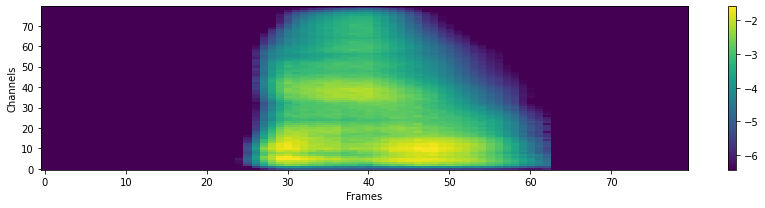

In [106]:
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(model.normalizer.inverse_normalize(output).squeeze().T.cpu().float(), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channelsa")
plt.tight_layout()

fig.canvas.draw()
plt.show()
plt.close()

In [107]:
with torch.no_grad():
    audio = waveglow.infer(denormalized_output.squeeze(0).transpose(1, 2), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=model.hparams.sampling_rate)

### GAN

In [6]:
%ls checkpoints

'GAN-epoch=36-step=3070.ckpt'
'GAN-epoch=67-step=5643.ckpt'
'MinMaxNormRun-epoch=4-step=414-val_loss=0.704835057258606.ckpt'
'NoSigmoid-epoch=86-step=7220-val_loss=0.481905072927475.ckpt'
'Run1-epoch=0-step=199.ckpt'
'Run1-epoch=41-step=3485-val_loss=1.0234405994415283.ckpt'
'Run2-epoch=44-step=3734-val_loss=0.9695601463317871.ckpt'
'testGAN-epoch=35-step=2987.ckpt'
'testGAN-epoch=4-step=414.ckpt'


In [7]:
checkpoint_path = 'checkpoints/GAN-epoch=36-step=3070.ckpt'
gan_model = MelGANTrainer.load_from_checkpoint(checkpoint_path)
_ = gan_model.cuda().eval().half()

In [20]:
z = torch.randn(1, gan_model.hparams.latent_size).cuda().half()

In [21]:
with torch.no_grad():
    output_gan = gan_model(z)

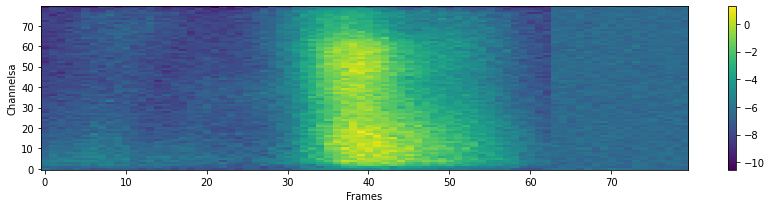

In [22]:
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(gan_model.normalizer.inverse_normalize(output_gan).squeeze().T.cpu().float(), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channelsa")
plt.tight_layout()

fig.canvas.draw()
plt.show()
plt.close()

In [23]:
denormalized_output_gan = gan_model.normalizer.inverse_normalize(output_gan)
with torch.no_grad():
    audio = waveglow.infer(denormalized_output_gan.squeeze(0).transpose(1, 2), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=gan_model.hparams.sampling_rate)

### DCGAN

In [50]:
%ls checkpoints

'DCGAN-epoch=82-step=6888.ckpt'
'GAN-epoch=48-step=4066.ckpt'
'GAN-epoch=67-step=5643.ckpt'
'MinMaxNormRun-epoch=4-step=414-val_loss=0.704835057258606.ckpt'
'NoSigmoid-epoch=86-step=7220-val_loss=0.481905072927475.ckpt'
'Run1-epoch=0-step=199.ckpt'
'Run1-epoch=41-step=3485-val_loss=1.0234405994415283.ckpt'
'Run2-epoch=44-step=3734-val_loss=0.9695601463317871.ckpt'
'testGAN-epoch=35-step=2987.ckpt'
'testGAN-epoch=4-step=414.ckpt'


In [51]:
checkpoint_path = 'checkpoints/DCGAN-epoch=82-step=6888.ckpt'
dc_gan_model = MelDCGANTrainer.load_from_checkpoint(checkpoint_path)
_ = dc_gan_model.cuda().eval().half()

In [52]:
z = torch.randn(1, dc_gan_model.hparams.latent_size).cuda().half()

In [53]:
with torch.no_grad():
    output_dc_gan = dc_gan_model(z)

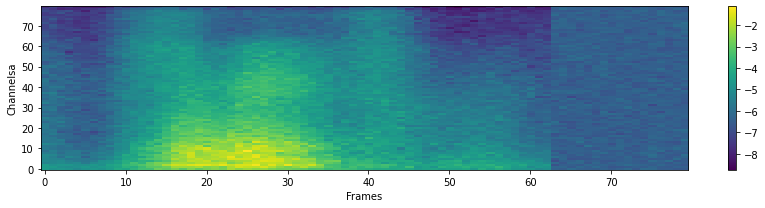

In [54]:
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(dc_gan_model.normalizer.inverse_normalize(output_dc_gan).squeeze().T.cpu().float(), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channelsa")
plt.tight_layout()

fig.canvas.draw()
plt.show()
plt.close()

In [55]:
denormalized_output_gan_dc = dc_gan_model.normalizer.inverse_normalize(output_dc_gan)
with torch.no_grad():
    audio = waveglow.infer(denormalized_output_gan_dc.squeeze(0).transpose(1, 2), sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=dc_gan_model.hparams.sampling_rate)